# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.linear_model import LinearRegression
import cv2
from collections import deque
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


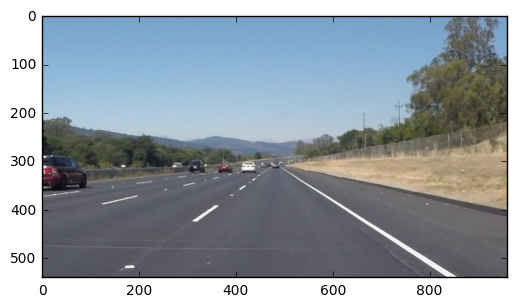

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
print(os.listdir("test_images/"))
test_images = ['test_images/'+file_name for file_name in os.listdir('test_images/')]

['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


run your solution on all test_images and make copies into the test_images directory).

# Data Exploration and 'Feature Engineering'

## A  peek at the individual images suggests that the region of interest does not change much
It may even be possible to work with only one region of interest
I will validate this observation by looking at the videos (though I suppose this shouldn't be done if we consider them to be the test set).

To be completely rigorous, one would have to consider different situations. 

You can make certain assumptions about the road. e.g. the incline of the path probably won't be above 60 degrees. We could then approximate the local curvature of the road with a sphere assuming varias radii and see how the visibility changes.  An interesting question one could examine mathematically is how does the range of vision change with the velocity of the car and the curvature. Being an engineer, one would also be wise to survey various locations to look for real-world situations you could not anticipate. For the purposes of this exercise, it's probably fine just to look at the videos and pictures.

test_images/solidWhiteCurve.jpg
this image is  <class 'numpy.ndarray'>  with dimensions  (540, 960, 3)


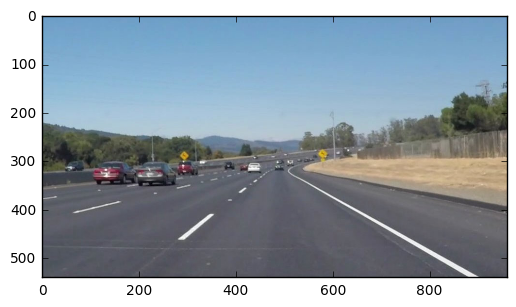

In [5]:
def show_image(path):
    image = mpimg.imread(path)
    print(path)
    print("this image is ",type(image)," with dimensions ", image.shape)
    plt.imshow(image)

show_image(test_images[0])


# Conclusion
My initial inspection found the area of interest to be (130,540) (400,320) (510,320) (900,540).

After fiddling around with the  region_of_interest function below, I found (130,540) (450,320) (530, 320) (950, 540). Including too much additional region creates unwanted lines

In [6]:
interest_poly = np.array([[130,540],[450,320],[530,320],[950,540]],np.int32)


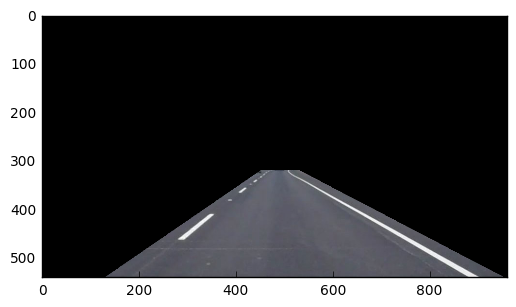

In [7]:
plt.imshow(region_of_interest(mpimg.imread(test_images[0]),[interest_poly]))

In [8]:
def apply_selected_region_of_interest(img):
    """
    wraps region_of_interest function with selected parameters
    """
    interest_poly = np.array([[130,540],[450,320],[530,320],[950,540]],np.int32)
    return region_of_interest(img,[interest_poly])

## Now, Let's examine the steps outlined in the lessons
1. Convert to greyscale
1. Blur the image to reduce 'overfitting'
1. Apply The Canny Edge Detection Algorithm
1. Use the Hough Transforms to find all line segments

I test the first 3 together since they form an independent unit from the 4th. (This is also conveniently how it is arranged in the lesson).

In [9]:
def plot_grayscale(img):
    """
    plots an image that is in the grayscale format
    """
    plt.imshow(img,cmap='gray')

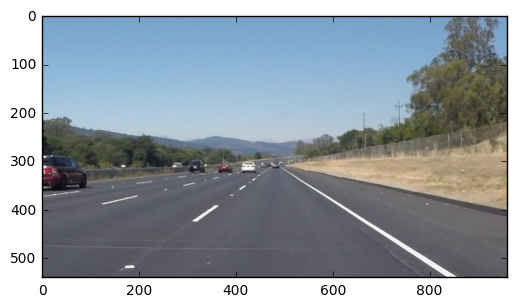

In [10]:
# Color scheme doesn't change if isn't grayscale
plot_grayscale(mpimg.imread(test_images[1]))

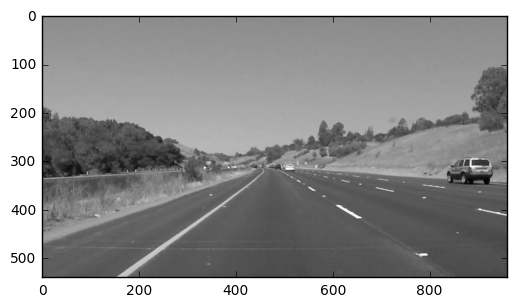

In [11]:
plot_grayscale(grayscale(mpimg.imread(test_images[2])))

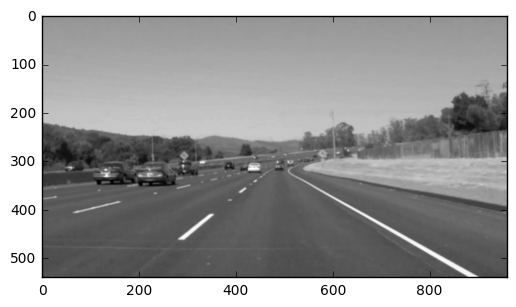

In [12]:
plot_grayscale(
    gaussian_blur(grayscale(mpimg.imread(test_images[0])),5)
)

In [13]:
#canny applied to grayscale is still grayscale
def test_canny(img, low_threshold, high_threshold, kernel_size):
    plot_grayscale(
        canny(
            gaussian_blur(grayscale(mpimg.imread(img)),kernel_size),
            low_threshold = low_threshold,
            high_threshold = high_threshold
        )
    )

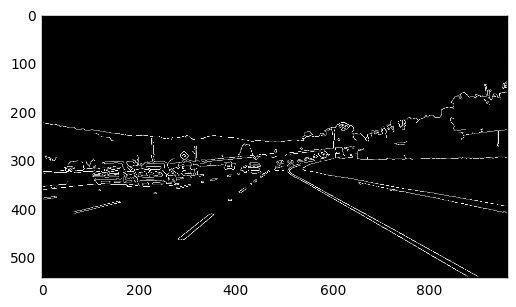

In [14]:
test_canny(test_images[0],50,150,3)

## Experimentation on Canny low_threshold, high_threshold parameters & kernel size

So far as I can tell, the canny algorithm is robust under different parameters at least to this problem of keeping lane lines. Unless you pick extreme parameters, it performs pretty well. I tested various combinations of low_threshold = (10, 50, 100, 200, 300) and high_threshold = (10, 50, 100, 200, 300), paying particular attention to the difference between white and yellow lines. Some points on these tests:


1.  The effect of low_threshold is secondary as long as the high_threshold is reasonably high. I held low_threshold at 10 and could drop high_threshold to about 70 before I became worried about noisy edges.
1. A high threshold around 300 is too high. Too many pixels are removed from consideration. 
1. I decided on a high_threshold around 150 because this errs on the side of caution. If the lane lines are not drawn, a high_threshold around 150 often detects the side of the road. 
1. Similarly, I broght the low_threshold to 30 because it allowed the detection of the side of the road in  the 4th test image
1. The kernel size has a significant effect. Growing it from 5 to 9 removes a lot of superfluous edges.  7 is tempting because this removes most of the objects with 'soft edges' like trees while keeping the most important outlines of said objects (the tree against the sky verses darker tree leaves against lighter tree leaves). I decided to keep the kernel size at 3 because this is necessary to detect the side of the road. I figure that later steps should bear more responsibility in fitting the final result. Keeping the kernel size at 7 would make for a fragile solution because  if the lane lines are less coherent, the canny algorithm might filter them out.
 - Compare test_canny(test_images[4],30,150,7) with test_canny(test_images[4],30,150,3)
1. if the high_threshold is lower than the low_threshold, the low_threshold behaves well. In fact, the function seems to force the lower value into the role of low_threshold and the larger number into the role of high_threshold.

### Final parameters chosen:
low_threshold = 50

high_threshold = 150

kernel_size = 3

### Some Consideration of Real-World conditions

The analysis above doesn't take into consideration variation in the real world. All the pictures are of sunny boulevards with clearly-drawn lines and dark asphault. Some questions we must ask: how does weather change the contrast of the images? What if the pictures aren't very bright? What if there is significant wear in the road? What if the cameras themselves are miscalibrated-- perhaps the lense is covered with a thin film of dust. 

# What we have so far

In [15]:
def clean_canny(img, low_threshold, high_threshold, kernel_size):
    """
    Applies a grayscale, gaussian blur, and then canny
    """
    return canny(
            gaussian_blur(grayscale(img),kernel_size),
            low_threshold = low_threshold,
            high_threshold = high_threshold
        )

In [16]:
def selected_clean_canny(img):
    return clean_canny(img, 50,150,3)

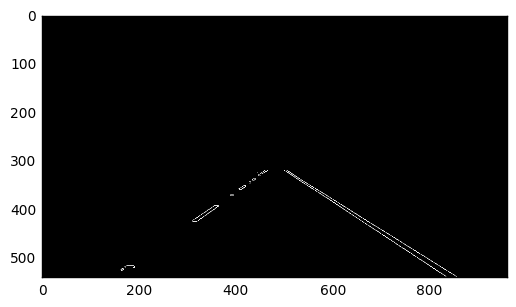

In [17]:
#note that the order of composition matters
plot_grayscale(
    apply_selected_region_of_interest(
        selected_clean_canny(
            mpimg.imread(test_images[1])
        )
    )
)

#I wonder if the generous region at the top will be problematic...

# Experiments with The Hough Transform

## Some basic considerations

Considering some edge cases where the Hough Transform approximations may result in distorted/incorrect results, we might consider the fact that around extremal points, the growth of a sine curve slows. This means that for any given tiny change in theta, the change in rho is even smaller. This means that the accumulator might erroneously count a cell as an intersection if two peaks are near each other. Two peaks are near each other if two points are near each other since  all  trig waves of the form xcos(theta) + ysint(theta) have the same period 2pi. I suspect that any issues caused by this can be fixed with enough resolution in theta. 

Since this is really equivalent to the difference between the two rho functions, there will be erroneous counts if  the space between rhos is greater than the largest possible difference. 

This won't be a big issue with multiple lines in the Hough space.

max line gap  above 5 picks out lines that aren't there in the left white lane.  the randomness of the Houhgh linesp funciton is such that if we use a line gap of  5, it picks up all the relevant lines with max_line_gap = 5 but not at max_line_gap=6. 

The min line length has no obvious effect on image 1. , but on other images, it introduces some lines that aren't directly on the lane lines.

The threshold tends to be robust to low numbers in the test images. The previous steps do a great job of filtering out noise. At around a threshold of 65, there starts to be problems as many dashed lanes are removed. I ended up picking 30 becuase it removes dashed lines close to the bottom fo the frame. 

Side note: Image 5 causes me to question the choice of region of interest. It includes a portion of the road which is  included as a line. 

threshold = 30

threshold = 20
min_line_len = 5
max_line_gap = 3

In [18]:
def hough_lines_image(img):
    canny = selected_clean_canny(img)
    region_of_interest = apply_selected_region_of_interest(canny)
    lines = hough_lines(region_of_interest,
                       rho = 1,
                       theta = math.pi/180,
                       threshold = 20, min_line_len = 3,
                       max_line_gap = 7)
    return weighted_img(lines, img,  α=0.8, β=1., λ=0.)

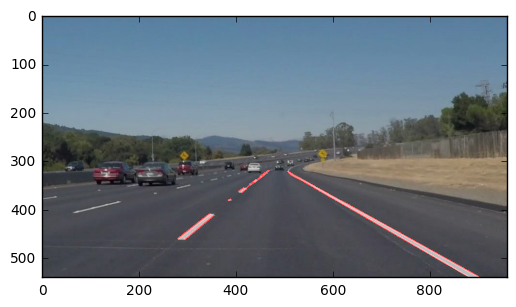

In [19]:
plt.imshow(hough_lines_image(mpimg.imread(test_images[0])))

#### Notes on Hough Lines Parameters

increasing the threshold to 20 points seems to remove most of the noise while preserving the important portions (i.e. nothing that should have been excluded was included). Conversely I see  no major false negative (by which I mean things that should have been included but was excluded); what remains is enough to construct a high-quality line. 


# More Experimentation to be done

### Final Version

In [20]:
def find_hough_lines(img):
    canny_image = selected_clean_canny(img)
    interest_canny = apply_selected_region_of_interest(canny_image)
    rho = 1
    threshold = 30
    theta = math.pi/180
    min_length = 3
    max_gap = 7
    lines = cv2.HoughLinesP(interest_canny, rho, theta, threshold, np.array([]), minLineLength = min_length, maxLineGap = max_gap)
    return lines

## Experiments on Lines

I ended up trying 3 methods.

Everything below assumes you separate all lines into left and right lane based on slope.
1. Because the two lines in the picture are pretty well separated (and hopefully previous steps have removed all noise) you can use linear regression to split out the second line from the right line. (i.e. basic linear regression can be used as a linear classifier.) All you need do is do the regression and look at the sign of the errors (residuals).

1.  You can represent each line segment in terms of its slope and projection to the bottom of the frame. Due to geometry, projecting downwards should be quite effective in splitting the lines into groups. In this representation it is also very easy to remove outliers and noise, which is why I expect it will be effective for more difficult videos. Once I have the four groups, I do a weighted average of slope by length of the line—it’s pretty evident that longer lines are better unless they are noise— and then pick out the top and bottom points of the line to draw.

1. For each lane, pick out two seeds at the bottom of a lane which start the left or right line. (I did not experiment with an algorithm to pick out the two seeds, though I don’t expect it to be terribly difficult) Then select lines upward by extending the lines up. This will create four regions. Then you can use some heuristics to determine whether each line should be added to which list of line segments. This opens a general discussion of clustering to discover these line segments. Hierarchical clustering is used to do something more general, and it motivated this idea in part. 


# Method 1

In [21]:
test_image = mpimg.imread(test_images[0])
canny_image = selected_clean_canny(test_image)
interest_canny = apply_selected_region_of_interest(canny_image)
rho = 1
threshold = 20
theta = math.pi/180
min_length = 5
max_gap = 3
lines = cv2.HoughLinesP(interest_canny, rho, theta, threshold, np.array([]), minLineLength = min_length, maxLineGap = max_gap)

In [22]:
def is_horizontal(slope):
    return abs(slope)<0.4 and abs(slope)>=0

In [23]:
def collect_left_right(lines):
    left, right = [], []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if not is_horizontal(slope):    
                if slope<0:
                    left.append((x1,y1))
                    left.append((x2,y2))
                else:
                    right.append((x1,y1))
                    right.append((x2,y2))
    return np.array(left), np.array(right)

In [24]:
left, right = collect_left_right(lines)

In [25]:
def get_lane_lines(lane):
    lm = LinearRegression()
    lm.fit(X = lane[:,0].reshape(-1,1),y=lane[:,1],)
    isleft = (lm.predict(lane[:,0].reshape(-1,1)) - lane[:,1] )<0
    isright = (~isleft)
    return lane[np.where(isleft)], lane[np.where(isright)]

In [26]:
def find_x(X,Y,max_y,min_y):
    """
    I find the relevant X's by using an inverse linear model
    """
    max_min_y = np.array((max_y,min_y)).reshape(-1,1)
    lm = LinearRegression()
    #here I do the inverse to find x for the y's
    lm.fit(Y.reshape(-1,1), X)
    Xs = lm.predict(max_min_y)
    return np.column_stack((Xs, max_min_y)).astype(int).flatten()

In [27]:
def fit1(lines,max_y, min_y):
    #split the hough lines into four groups
    left, right = collect_left_right(lines)
    ll, lr = get_lane_lines(left)
    rl, rr = get_lane_lines(right)
    
    #store results
    accum = []
    #the bounding y's for the area
    max_min_y = np.array((max_y,min_y)).reshape(-1,1)
    
    #find x's corresponding to bounding y's
    for points in [ll,lr, rl, rr]:
        accum.append(
            np.array((find_x(points[:,0].reshape(-1,1), points[:,1], max_y,min_y)))
        )
    result = np.array(accum)
    
    
    return np.reshape(result,(result.shape[0],1,result.shape[1]))


In [28]:
result = fit1(lines, 540,320)

/Users/kevinko/.virtualenvs/cv3/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


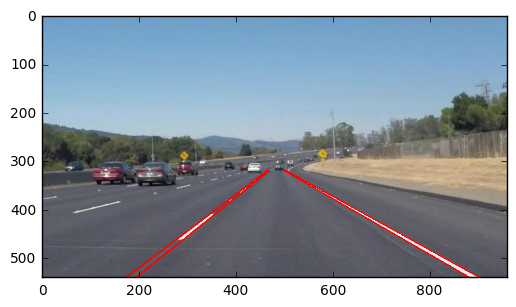

In [29]:
test_img = mpimg.imread(test_images[0])
draw_lines(test_img,result)
plt.imshow(test_img)

# Method 2

In [30]:
test_image = mpimg.imread(test_images[0])
canny_image = selected_clean_canny(test_image)
interest_canny = apply_selected_region_of_interest(canny_image)
rho = 1
threshold = 20
theta = math.pi/180
min_length = 5
max_gap = 3
lines = cv2.HoughLinesP(interest_canny, rho, theta, threshold, np.array([]), minLineLength = min_length, maxLineGap = max_gap)


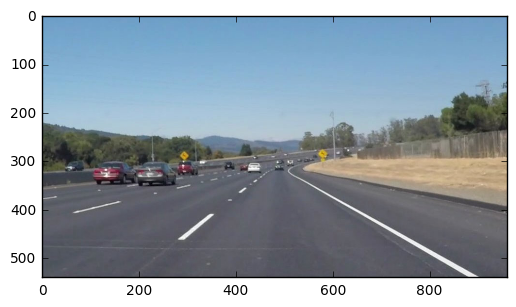

In [31]:
plt.imshow(mpimg.imread(test_images[0]))

In [32]:
def compute_line_attrib(x1, y1, x2, y2, accum, max_y):
    """
    For a line defined by two points, computes the slope, x_intercept,
    distance, and distance
    """
    slope = (y2 - y1) / (x2 - x1)
    distance = math.sqrt((y2-y1)**2 + (x2-x1)**2) #distance of line segment
    project_x = (max_y-y2)/slope + x2 #projection of extended line onto bottom of picture
    line_characteristics = (slope, project_x, distance)
    accum.append(line_characteristics)
    return accum

In [33]:
def is_horizontal(slope):
    return abs(slope)<0.4 and abs(slope)>=0

In [34]:
test_img = mpimg.imread(test_images[0])
def collect_left_right2(lines, max_y):
    """
    For a set of lines, computes all of the line attributes: slope, 
    x_intercept,distnace, and distance
    """
    right_lane, left_lane = [], []
    if len(lines) != 0:
        for line in lines:
            for x1, y1, x2, y2 in line:
                slope = (y2 - y1) / (x2 - x1)
                if not is_horizontal(slope):
                    if slope < 0 : 
                        left_lane = compute_line_attrib(x1, y1, x2, y2, left_lane, max_y)
                    else:
                        right_lane = compute_line_attrib(x1, y1, x2, y2, right_lane, max_y)
    return np.array(right_lane), np.array(left_lane)

In [35]:
def is_not_outlier(features, outlier_threshold):
    """
    Takes features and returns boolean stating whether greater than outlier_threshold
    standard deviations away from mean, where outlier_threshold is a float
    and a feature is a column. Result must be true for all columns to not 
    be an outlier.
    """
    means = features.mean(axis = 0)
    std = features.std(axis = 0)
    outlier = ((features - means)/std <= outlier_threshold).all(axis = 1)
    return outlier

In [36]:
right_lane, left_lane = collect_left_right2(lines, test_img.shape[0])

In [37]:
def partition(features,column):
    """
    splits a set of features along the mean. i.e. if a column
    has greater than the mean, it is the right feature,
    if it ias less, than it is the left
    """
    is_left = features[:,column]<features[:,column].mean(axis=0)
    left = features[is_left]
    right = features[~is_left]
    if len(left)==0 and len(right==0):
        print("both partitions are empty")
    elif len(right)==0:
        print("length left is " + str(len(left)))
        print("right partition is empty")
    elif (len(left)==0):
        print("length right is" + str(len(right)))
        print("left partition is empty")
    return left, right

In [38]:
left, right = partition(right_lane,1)

In [39]:
def weighted_avg(weight,feature):
    return weight.dot(feature)/weight.sum()

In [40]:
def extrapolate_line(slope,x2,y2,y1):
    """
    for a fixed slope and x2, y1 and y2, find x1
    """
    return x2 + (y1 - y2)/slope
    

In [41]:
def fit2(lines,max_y, min_y):
    """
    returns final four points needed to fit lane lines
    """
    left, right = collect_left_right2(lines, max_y)
    remove_left_outliers = is_not_outlier(left[:,:2],2) #use the slope and proj_x to find outliers 
    left = left[remove_left_outliers]              #remove those more than 2 sd from mean
    remove_right_outliers = is_not_outlier(right[:,:2],2)
    right = right[remove_right_outliers]
    ll, lr = partition(left,1) #partition along the projection into x axis
    rl, rr = partition(right,1)
    def avg_weight_by_length(line_attrib):
        # taking in an array of line characteristics calculate weighted average of line characteristic
        # return intercept (pro)
        return weighted_avg(line_attrib[:,2],line_attrib[:,0]), weighted_avg(line_attrib[:,2], line_attrib[:,1])
    slope_ll, proj_ll = avg_weight_by_length(ll)
    slope_lr, proj_lr = avg_weight_by_length(lr)
    slope_rl, proj_rl = avg_weight_by_length(rl)
    slope_rr, proj_rr = avg_weight_by_length(rr)
    #note a line is described by proj_ll, max_y, x_ll, min_y
    x_ll = extrapolate_line(slope_ll, proj_ll, max_y,min_y)
    x_lr = extrapolate_line(slope_lr, proj_lr, max_y, min_y)
    x_rl = extrapolate_line(slope_rl, proj_rl, max_y,min_y)
    x_rr = extrapolate_line(slope_rr, proj_rr, max_y,min_y)
    return np.array(([math.floor(proj_ll), max_y,math.floor(x_ll),min_y], 
                    [math.floor(proj_lr),max_y,math.floor(x_lr),min_y],
                    [math.floor(proj_rl),max_y,math.floor(x_rl),min_y],
                    [math.floor(proj_rr),max_y,math.floor(x_rr),min_y])
                   ).reshape((4,1,4))
    

In [42]:
result = fit2(lines,540,320)

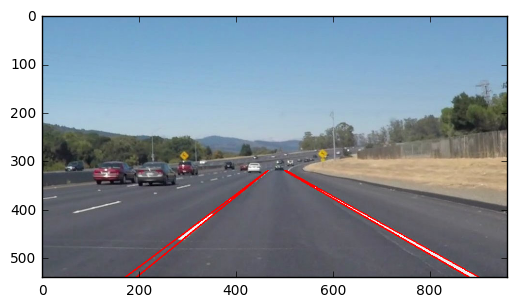

In [43]:
test_img = mpimg.imread(test_images[0])
draw_lines(test_img,result)
plt.imshow(test_img)

In [44]:
def draw_line(img, line, color=[255, 0, 0], thickness=2):
    x1,y1,x2,y2 = line
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)


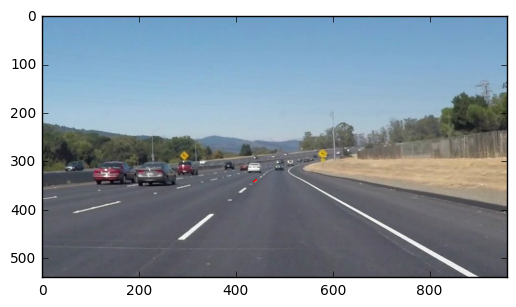

In [45]:
test_img = mpimg.imread(test_images[0])
draw_line(test_img, lines[10][0], color = [255,0,0], thickness= 2)
plt.imshow(test_img)

Note: This method seems to work decently after finding a bug in the initializing Hough Lines(I had a theta parameter that was too large)

In [46]:
def slope_change_too_high(slope_previous_laneline, slope_current_laneline):
    return abs((slope_previous_laneline - slope_current_laneline)/(slope_previous_laneline)) > 0.1

In [47]:
def slope(line):
    for x1, y1, x2, y2 in line:
        return (y2-y1)/(x2-x1)

In [48]:
def smooth_line(previous_lanes, current_lanes):
    adjusted = []
    for previous_laneline, current_laneline in zip(previous_lanes, current_lanes):
        if slope_change_too_high(slope(previous_laneline),slope(current_laneline)): #greater than 10% change
            adjusted.append(previous_laneline) #discard previous result
        else:
            adjusted.append(current_laneline)
    return np.array(adjusted)

In [49]:
def exponential_smooth(queue):
    factor

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [50]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [53]:
queue_last_1 = deque([]) #each function call has access to this effectively global queue
previous_result_queue = deque([])
#not the most efficient way to do this
def process_image(image,method = 1):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    lines = find_hough_lines(image)
    
    if method == 2:
        #this method needs more work before I can use it on this problem. 
        lane_lines = fit2(lines, 540, 320)
    else:
        lane_lines = fit1(lines, 540, 320)
    
    #guarding against extreme change
    #the strategy that I use is to ignore a new line if the slope changes by more than 40%
    #If this doesn't work, I will implement exponential smoothing
    if len(queue_last_1)>0:
        previous = queue_last_1[-1]
        lane_lines = smooth_line(previous, lane_lines)    
        
    if len(queue_last_1) == 1:
        queue_last_1.popleft() #maintain length 1
    queue_last_1.append(lane_lines) #append latest result
    
    if len(previous_result_queue)>0:
        lane_lines = 0.8 * lane_lines + 0.2 + previous_result #exponential_smooth
        previous_result_queue.popleft() #keep previous result
        previous_result_queue.append(lane_lines)
    
    result = draw_lines(image, lane_lines)
    
    return image

Let's try the one with the solid white lane on the right first ...

In [54]:
queue_last_1 = deque([]) #clear the queue of past information from the function call
previous_result_queue = deque([])
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:03<00:00, 61.50it/s]     | 8/222 [00:00<00:02, 74.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.12 s, sys: 272 ms, total: 3.39 s
Wall time: 4.09 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [55]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [56]:
queue_last_1 = deque([])
previous_result_queue = deque([])
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:11<00:00, 59.04it/s]     | 7/682 [00:00<00:10, 64.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 9.86 s, sys: 792 ms, total: 10.7 s
Wall time: 12.1 s


In [333]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


# Resubmission 1:
   1. The main change that I made was to  create a range which I stated was horizontal. These were lines with slopes (the absolute value of) between 0 and 0.4. These lines I filter out. 
   1. I added exponential smoothing. The most recent result gets a weight of 0.8, previous result gets a weight of 0.2. 
   1. I  changed  the constant of accepted change from 0.2 to 0.1. Now if the slope changes more than 0.1 from the previous slope, it is discarded. this may be too strict in real life because the wheel might be turned so that the change is more the 0.1 quite easily.
    

# Original Comments

In all, I am satisfied with my work on the project. I prototyped 3 methods :

Everything below assumes you separate all lines into left and right lane based on slope.
1. Because the two lines in the picture are pretty well separated (and hopefully previous steps have removed all noise) you can use linear regression to split out the second line from the right line. (i.e. basic linear regression can be used as a linear classifier.) All you need do is do the regression and look at the sign of the errors (residuals).

1.  You can represent each line segment in terms of its slope and projection to the bottom of the frame. Due to geometry, projecting downwards should be quite effective in splitting the lines into groups. In this representation it is also very easy to remove outliers and noise, which is why I expect it will be effective for more difficult videos. Once I have the four groups, I do a weighted average of slope by length of the line—it’s pretty evident that longer lines are better unless they are noise— and then pick out the top and bottom points of the line to draw.

1. For each lane, pick out two seeds at the bottom of a lane which start the left or right line. Then select lines upward by extending the lines up. This will create four regions. Then you can use some heuristics to determine whether each line should be added to which list of line segments. This opens a general discussion of clustering to discover these line segments. Hierarchical clustering is used to do something more general, and it motivated this idea in part. 

The current algorithm fails in that it does not deal naturally with noise. If there are even a few points that are outliers, the least squares regression will change drastically. I deal with this in the simplest way possible for the first two videos by checking if the slope changes more than 20% and then keeping the old slope if this is the case. A more robust method to be to use exponential smoothing to deal with this issue. 

The second method, is better at dealing with outliers. I simply need to experiment with how best to naturally cluster the representations and pick out the four best clusters. I suspect that heirarchical clustering or some variant thereof which naturally selects dense clusters is best.  Currently, I use a naive method which assume that the projection is a normal distribution and removes everything 2 standard deviations away from the mean. In fact, it is possible to remove all points, which happens in a few yellow frames. 

The third method does not deal well with outliers and is clunky to implement, so I didn't do much beyond defining the method that takes the two seeds. 

Unfortunately, I've way overshot the time allocated for this project, so I cannot explore the second method further.  With more experience will hopefully come more faculty with the language and faster iterations.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [88]:
queue_last_1 = deque([])
previous_result_queue = deque([])
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4



 56%|█████▌    | 140/251 [00:05<00:04, 22.41it/s]

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.


 56%|█████▌    | 140/251 [00:15<00:12,  8.86it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Method 3 
- This method was not completed and is included here for my notes.  The idea is to once you have split out the right and left lanes to:

For each lane, pick out two seeds at the bottom of a lane which start the left or right line. (I did not experiment with an algorithm to pick out the two seeds, though I don’t expect it to be terribly difficult) Then select lines upward by extending the lines up. This will create four regions. Then you can use some heuristics to determine whether each line should be added to which list of line segments. This opens a general discussion of clustering to discover these line segments. Hierarchical clustering is used to do something more general, and it motivated this idea in part. 

My idea for picking out the two seeds is to note that if the lines are sufficiently clean, you can always pick out the left line of the lane. Simply sort the x axis and the lowest will be the left. Then simply calculate line with all other points. The line for the correct second seed will be below all other lines/points.

In [574]:
def extrapolate(slope, x2, y2, x_new):
    return slope*(x_new-x2) + y2

In [1021]:
def collect_left_right_p(lines):
    left = []
    right = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope < 0:
                left.append(line)
            else:
                right.append(line)
    left = np.array(left)
    right = np.array(right)
    return left.reshape((left.shape[0],left.shape[2])) , right.reshape((right.shape[0],right.shape[2]))

In [1022]:
def fit2(lines,max_y, min_y):
    left, right = collect_right_left_p(lines)
    ll, lr = get_lane_lines2(left)
    rl, rr = get_lane_lines2(right)
    

In [575]:
def in_interval(value, tolerance, new_value):
    return (new_value > (value-tolerance)) and (new_value < (value+tolerance))

In [957]:
left, right = collect_left_right_p(lines)

In [504]:
def draw_line(img, line, color=[255, 0, 0], thickness=2):
    x1,y1,x2,y2 = line
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)



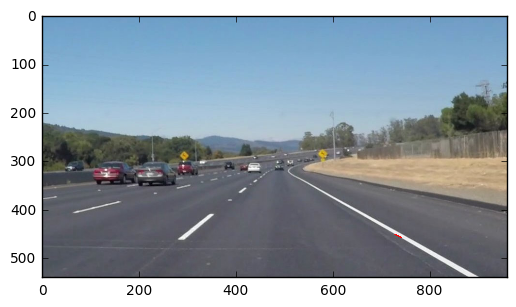

In [514]:
test_img = mpimg.imread(test_images[0])
draw_line(test_img,lines[2][0])
plt.imshow(test_img)

In [644]:
l1 = [True]
px1, py1, px2, py2 = reorder[0]
slope = (py2-py1)/(px2-px1)

for i in range(1,reorder.shape[0]):
    x1,y1,x2,y2 = reorder[i]
    next_possible = extrapolate(slope,px2,py2,x1)
    accept = in_interval(y1,1.8,next_possible)
    l1.append(accept)
    if accept:
        px1,py1,px2,py2 = x1,y1,x2,y2
        slope = (py2-py1)/(px2-px1)
    

In [903]:
def get_lane_lines2(lane_lines):
    reordered=lane_lines[lane_lines[:,0].argsort()].copy()
    l1 = [reordered[0]]
    l2 = [reordered[1]]
    reordered = reordered[2:]
    switch = 0
    while len(reordered)>0:
        if switch ==0:
            px1, py1, px2, py2 = l1[-1]
            slope = (py2-py1)/(px2-px1)
            switch = 1
        else:
            px1, py1, px2, py2 = l2[-1]
            slope = (py2-py1)/(px2-px1)
            switch = 0
            
        
        candidates = []
        for line in reordered:
            x1, y1, x2, y2 = line
            next_possible = extrapolate(slope, px2, py2, x1)
            candidates.append(y1-next_possible)
        current_min = abs(candidates[0])
        current_min_index = 0
        for i in range(1,len(reordered)):
            if abs(candidates[i]) <current_min:
                current_min = abs(candidates[i])
                current_min_index = i
        if switch ==0:
            l1.append(reordered[current_min_index])
        else:
            l2.append(reordered[current_min_index])
        reordered = np.delete(reordered,current_min_index,axis = 0)
        
    return l1, l2
            
            
    

In [904]:
l1, l2 = get_lane_lines2(right)

In [856]:
get_lane_lines2(left)

[True, False, False, False, False, False]

## Next version

Consider extrapolated lines and next closest point(can use ordering for this)
unless extrapolated lines cross before both points(there are cases where it crosses before one but not the other?), the closest to extrapolated y wins (or x, choose convention)
otherwise reverse rule

The previous version clearly failed on the left lane where line segments are sparser. Next I will try a strategy where given the two starting points, you extend the lines and look at where the next potential starting point lies compared to  the  the lines. There are 4 regions where you can get from the intersecting lines. Because the  hough lines are not supposed to intersect in the picture, you can usually decide quite easily which line, left or right you want to add it to.  In the two regions where it is less obvious, you rely on a decision rule with slope of the next potential line and the distance from the end-point of the current line. 


A note on obtaining starting points. I believe you can obtain reliably with sorting the x axis.(There is a nice structure to the output of the open cv hough lines algorithm.)



In [908]:
def extrapolate(slope, x2, y2, x_new):
    return slope*(x_new-x2) + y2

In [919]:
def get_lane_lines3(lane_lines):
    reordered=lane_lines[lane_lines[:,0].argsort()].copy()
    l = [reordered[0]] #left line
    r = [reordered[1]] #right line
    reordered = reordered[2:]
    for line in reordered:
        x1, y1, x2, y2 = line
        slope = (y2-y1)/(x2-x1)
        
        x1_l, y1_l, x2_l, y2_l = l[-1]
        slope_l = (y2_l-y1_l)/(x2_l-x1_l)
        l_extrapolate = extrapolate(slope_l, x2_l, y2_l, x1)
        l_prediction_error = y1-l_extrapolate
        
        x1_r, y1_r, x2_r, y2_r = r[-1]
        slope_r = (y2_r-y1_r)/(x2_r-x1_r)
        r_extrapolate = extrapolate(slope_r, x2_r, y2_r, x1)
        r_prediction_error = y1- r_extrapolate
        
        if l_prediction_error>=0 and r_prediction_error<0:
            #This rule is not infallible
            l.append(line)
        elif l_prediction_error<0 and r_prediction_error>=0:
            r.append(line)
        else:
            #l_prediction_error>=0 and r_prediction_error>=0
            #l_prediction_error<=0 an l_prediction_error<=0
            #the less obvious cases
            slope_similarity_l = (slope - slope_l)/slope_l
            slope_similarity_r = (slope - slope_r)/slope_r
            
            distance_l = math.sqrt((x2-x2_l)**2 + (y2-y2_l)**2)
            distance_r = math.sqrt((x2-x2_r)**2 + (y2-y2_r)**2)
            
            if abs(distance_l - distance_r) < 2:
                if slope_similarity_l > slope_similarity_r:
                    l.append(line)
                else:
                    r.append(line)
            else:
                if distance_l < distance_r:
                    l.append(line)
                else:
                    r.append(line)
            
    return np.array(l), np.array(r)

In [984]:
test = get_lane_lines3(left)

In [986]:
test = test[0].reshape((test[0].shape[0],1,test[0].shape[1]))

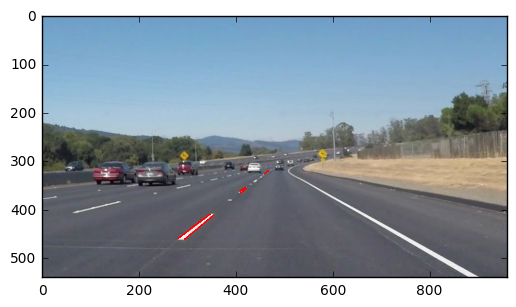

In [987]:
test_img = mpimg.imread(test_images[0])
draw_lines(test_img,test)
plt.imshow(test_img)